# Build Figures

Make all figures in this notebook to keep the results reproducible and the styling consistent.

Created: 2021/04/11
Author:  Andrew Weng

In [1]:
import os, sys

if os.path.basename(os.getcwd()) == 'code':
    os.chdir('../')
sys.path.append('code')

import numpy as np
import pandas as pd
import glob
import pprint
from scipy.stats import pearsonr
from datetime import datetime
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression
import seaborn as sns
from matplotlib import pyplot as plt
import re
from src.formation import FormationCell
from src.utils import get_label_registry

assert os.path.basename(os.getcwd()) == 'project-formation'

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

## Configure plot settings

In [3]:
# Configure plot settings
plt.rc('font', **{'family'     : 'sans-serif',
                  'sans-serif' : ['Arial'],
                  'size': 18
                  })
plt.rc('figure', **{'autolayout' : True,
                    'figsize'    : (7, 5),
                    'facecolor'  : 'white',
                    'dpi'        : 150
                    })
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')
plt.rc('axes',  labelsize='medium', grid=False)
plt.rc('axes',  titlesize='medium')
plt.rc('legend', fontsize='medium')


## Configure globals

In [4]:
# Formation types
CELL_BASE = 7
CELL_FAST = 33
COLOR_BASE = 'k'
COLOR_FAST = np.array([44, 121, 245])/255
COLOR_FAST_RT = 'b'
COLOR_FAST_HT = 'r'
LINESTYLE_BASE = ':'
LINESTYLE_FAST = '-'

# Pos/neg electrode colors
COLOR_POS = 'b'
COLOR_NEG = 'r'
COLOR_FULL_CELL = 'k'

COLOR_REF = (0.7, 0.7, 0.7)

NOMINAL_CAPACITY_AH = 2.36
CAPACITY_LIMITS_AH = (0.8, 2.4)
TARGET_RETENTION = 0.8

## Load resources

In [5]:
cell_dict = dict()
cellid_list = np.arange(1, 41)

for cellid in cellid_list:
    cell_dict[cellid] = FormationCell(cellid)

# Figure 1: Concept Illustration

In [6]:
df_base_form = cell_dict[CELL_BASE].get_formation_data()
df_fast_form = cell_dict[CELL_FAST].get_formation_data()

df_base_form = df_base_form[df_base_form['Test Time (s)'] > 86400]
df_fast_form = df_fast_form[df_fast_form['Test Time (s)'] > 86400]

(-1.0, 65.0)

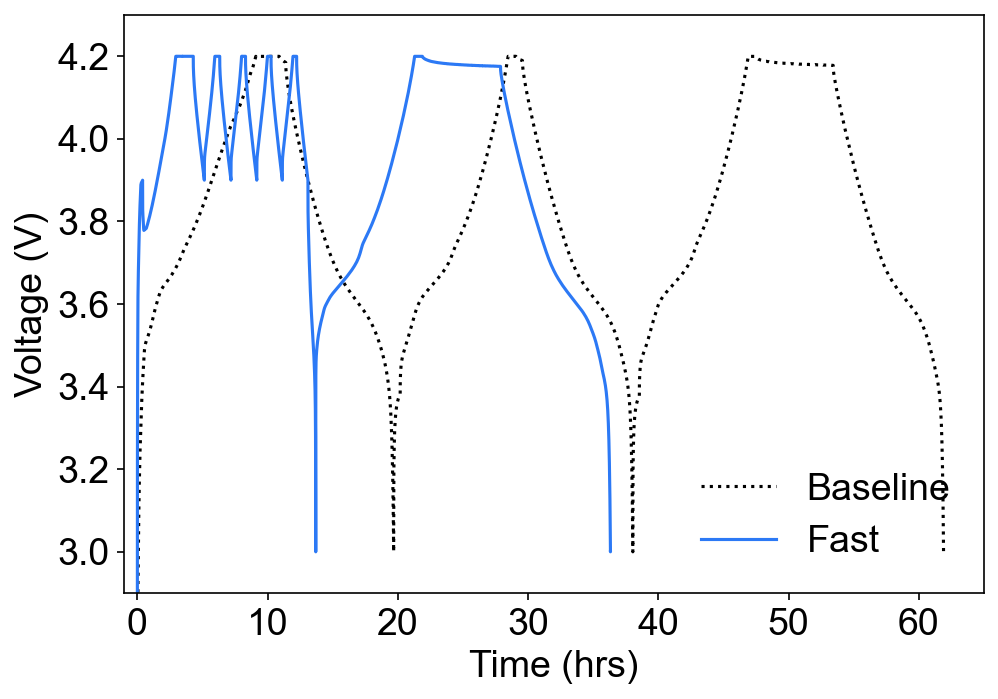

In [7]:
plt.figure()

plt.plot((df_base_form['Test Time (s)'] - 86400)/3600, df_base_form['Potential (V)'], 
         color=COLOR_BASE, linestyle=LINESTYLE_BASE)
plt.plot((df_fast_form['Test Time (s)'] - 86400)/3600, df_fast_form['Potential (V)'], 
         color=COLOR_FAST, linestyle=LINESTYLE_FAST)
plt.xlabel('Time (hrs)')
plt.ylabel('Voltage (V)')
lgd = plt.legend(['Baseline', 'Fast'], frameon=False)
plt.ylim((2.9, 4.3))
plt.xlim((-1, 65))


In [8]:
df_base_rpt = cell_dict[CELL_BASE].get_aging_data_timeseries()
df_base_rpt = df_base_rpt[df_base_rpt['Cycle Number'] < 5]
df_base_rpt = df_base_rpt[df_base_rpt['Cycle Number'] > 1]

df_fast_rpt = cell_dict[CELL_FAST].get_aging_data_timeseries()
df_fast_rpt = df_fast_rpt[df_fast_rpt['Cycle Number'] < 5]
df_fast_rpt = df_fast_rpt[df_fast_rpt['Cycle Number'] > 1]

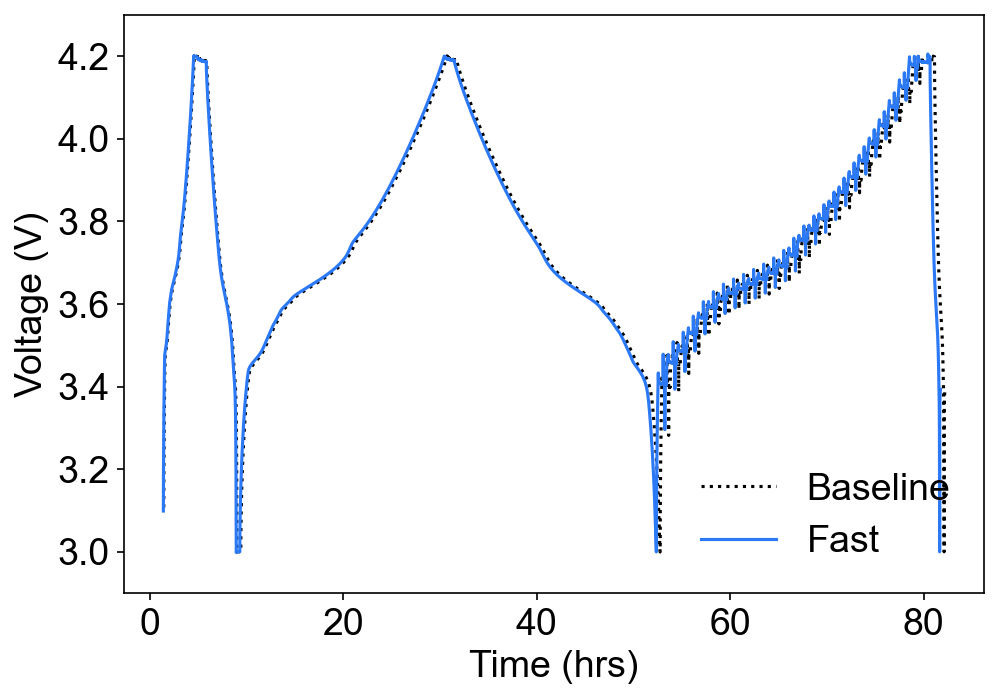

In [9]:
plt.subplot()

plt.plot(df_base_rpt['Test Time (s)'] / 3600, df_base_rpt['Potential (V)'], 
         color=COLOR_BASE, linestyle=LINESTYLE_BASE)
plt.plot(df_fast_rpt['Test Time (s)'] / 3600, df_fast_rpt['Potential (V)'], 
         color=COLOR_FAST, linestyle=LINESTYLE_FAST)

plt.xlabel('Time (hrs)')
plt.ylabel('Voltage (V)')
plt.ylim((2.9, 4.3))
plt.legend(['Baseline', 'Fast'], frameon=False)

In [10]:
df_base_cyc = cell_dict[CELL_BASE].get_aging_data_cycles()

idx = np.where((df_base_cyc['Total Charge Time (s)'] > 8500) |
               (df_base_cyc['Total Charge Time (s)'] < 100))[0]

df_base_cyc['Discharge Capacity (Ah)'][idx] = np.nan

/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [11]:
df_fast_cyc = cell_dict[CELL_FAST].get_aging_data_cycles()

idx = np.where((df_fast_cyc['Total Charge Time (s)'] > 8500) |
               (df_fast_cyc['Total Charge Time (s)'] < 100))[0]

df_fast_cyc['Discharge Capacity (Ah)'][idx] = np.nan

/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


(0.0, 500.0)

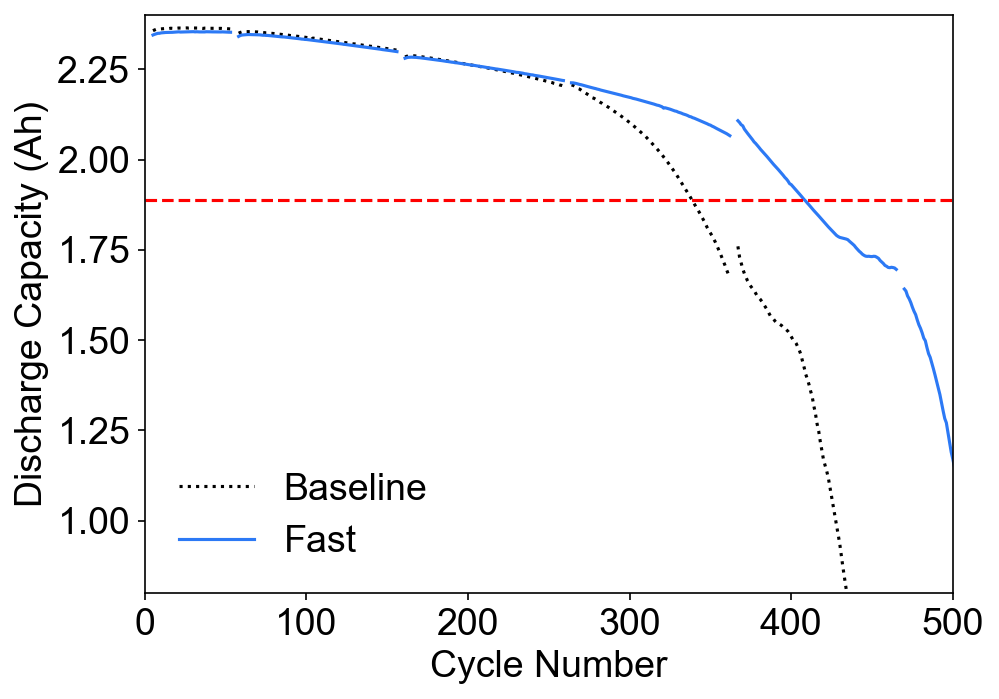

In [12]:
plt.figure()

plt.plot(df_base_cyc['Cycle Number'], df_base_cyc['Discharge Capacity (Ah)'], 
         color=COLOR_BASE, linestyle=LINESTYLE_BASE)
plt.plot(df_fast_cyc['Cycle Number'], df_fast_cyc['Discharge Capacity (Ah)'], 
         color=COLOR_FAST, linestyle=LINESTYLE_FAST)
plt.axhline(y=TARGET_RETENTION*NOMINAL_CAPACITY_AH , color='r', linestyle='--')
plt.xlabel('Cycle Number')
plt.ylabel('Discharge Capacity (Ah)')
plt.legend(['Baseline', 'Fast'], frameon=False)
plt.ylim(CAPACITY_LIMITS_AH)
plt.xlim((0, 500))

<ipython-input-13-c4a4451f2460>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_base_deltav['Test Time (s)'] -= np.min(df_base_deltav['Test Time (s)'])
<ipython-input-13-c4a4451f2460>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fast_deltav['Test Time (s)'] -= np.min(df_fast_deltav['Test Time (s)'])


(0.0, 6.7)

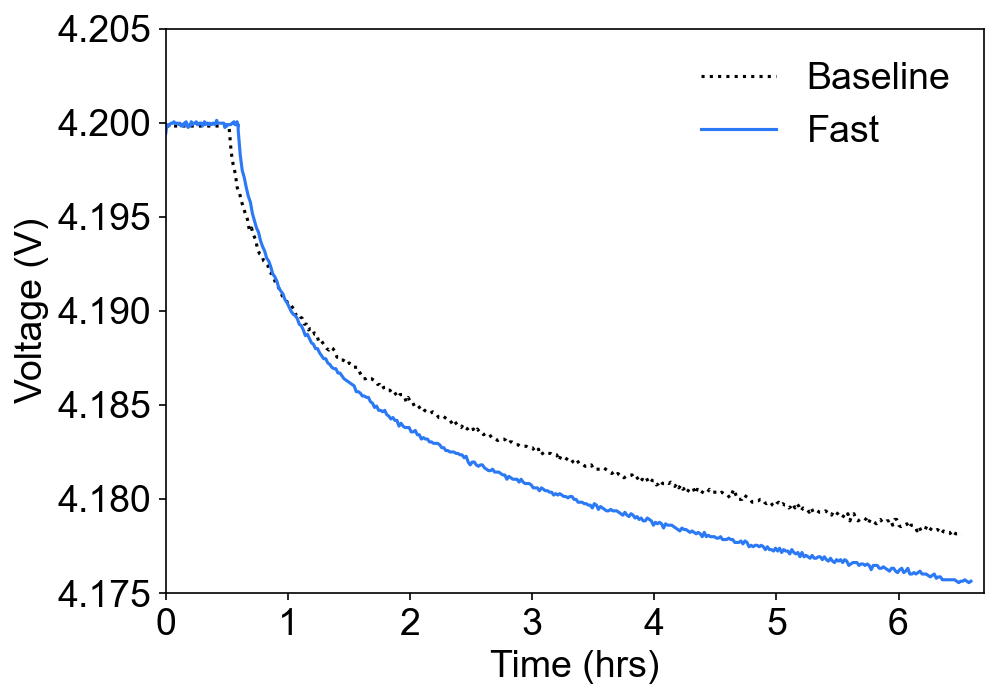

In [13]:
# Process voltage decay signal during 12-hour rest step
STEP_INDEX_6HR_REST = 12
CYCLE_INDEX_6HR_REST = 3
VOLTAGE_MAXIMUM = 4.2

df_base_deltav = df_base_form[(df_base_form['Cycle Number'] == 3) &
                              (
                                  (df_base_form['Step Index'] == 11) | 
                                  (df_base_form['Step Index'] == 12)
                              )]

df_base_deltav['Test Time (s)'] -= np.min(df_base_deltav['Test Time (s)'])

df_fast_deltav = df_fast_form[(df_fast_form['Cycle Number'] == 7) &
                              (
                                  (df_fast_form['Step Index'] == 13) | 
                                  (df_fast_form['Step Index'] == 12)
                              )]

df_fast_deltav['Test Time (s)'] -= np.min(df_fast_deltav['Test Time (s)'])

plt.figure()

plt.plot((df_base_deltav['Test Time (s)'])/3600, df_base_deltav['Potential (V)'], 
         color=COLOR_BASE, linestyle=LINESTYLE_BASE)
plt.plot((df_fast_deltav['Test Time (s)'])/3600, df_fast_deltav['Potential (V)'], 
         color=COLOR_FAST, linestyle=LINESTYLE_FAST)

plt.xlabel('Time (hrs)')
plt.ylabel('Voltage (V)')
lgd = plt.legend(['Baseline', 'Fast'], frameon=False)
plt.ylim((4.175, 4.205))
plt.xlim((0, 6.7))

In [14]:
hppc_base_list = cell_dict[CELL_BASE].process_diagnostic_hppc_data()
# Unpack data from first available cycle
df_hppc_base = hppc_base_list[0]['data']

hppc_fast_list = cell_dict[CELL_FAST].process_diagnostic_hppc_data()
# Unpack data from first available cycle
df_hppc_fast = hppc_fast_list[0]['data']

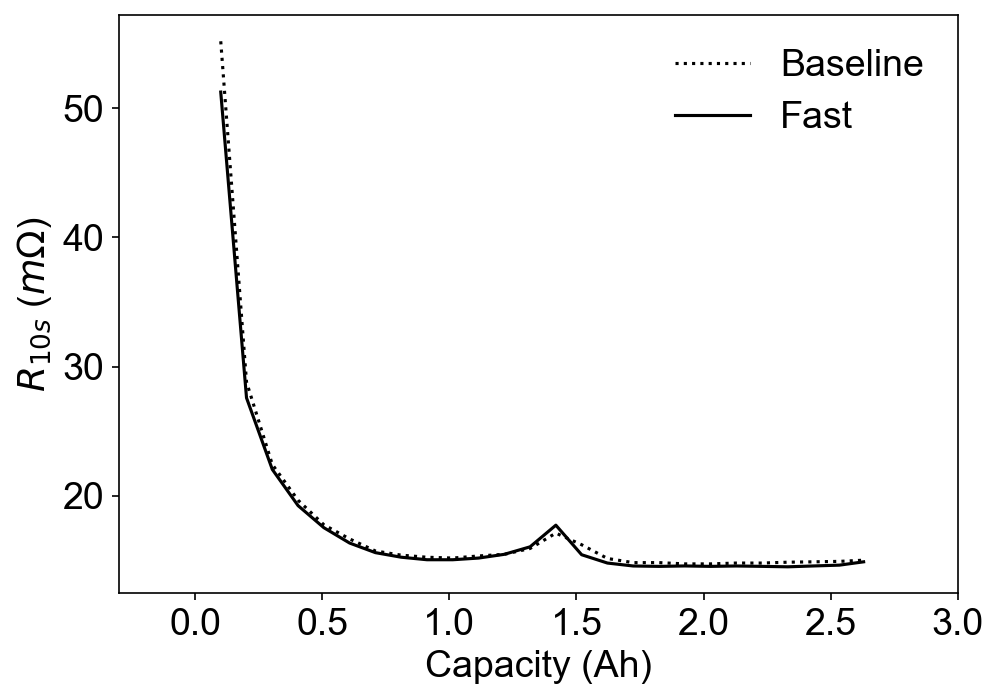

In [15]:
plt.figure()

plt.plot(df_hppc_base['capacity'],
         df_hppc_base['resistance_10s_ohm']*1000, 
         color=COLOR_BASE, linestyle=LINESTYLE_BASE)

plt.plot(df_hppc_fast['capacity'],
         df_hppc_fast['resistance_10s_ohm']*1000, 
         color='k', linestyle=LINESTYLE_FAST)
         
plt.xlabel('Capacity (Ah)')
plt.ylabel('$R_{10s}$ ($m\Omega$)')
plt.xlim((-0.3, 3))
lgd = plt.legend(['Baseline', 'Fast'], frameon=False)

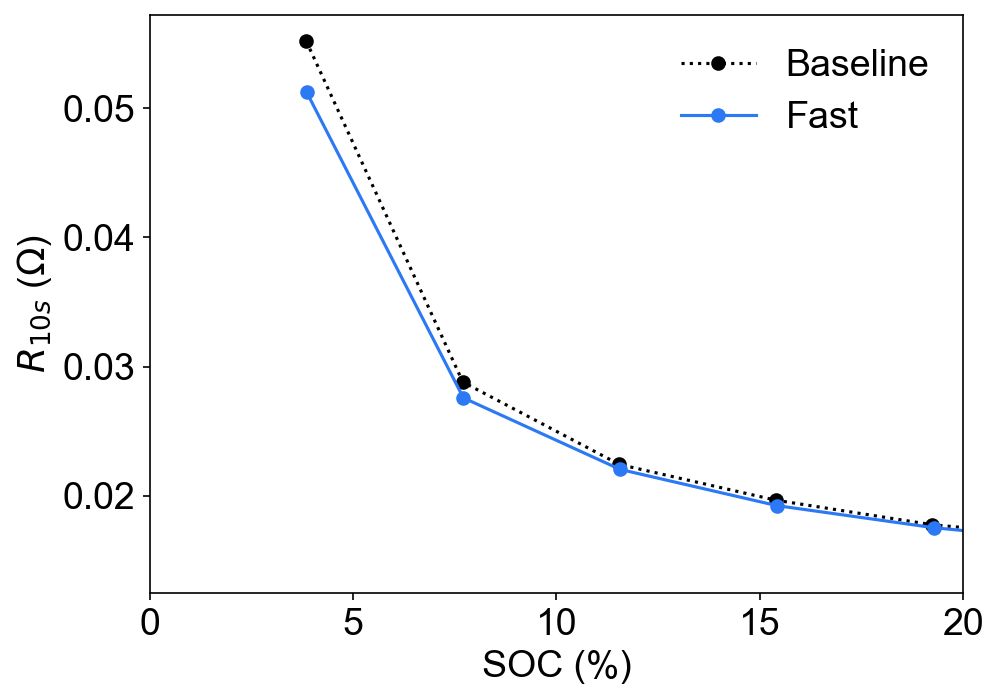

In [16]:
plt.figure()

plt.plot(df_hppc_base['capacity']/np.max(df_hppc_base['capacity'])*100,
         df_hppc_base['resistance_10s_ohm'], 
         color=COLOR_BASE, linestyle=LINESTYLE_BASE, marker='o')

plt.plot(df_hppc_fast['capacity']/np.max(df_hppc_fast['capacity'])*100,
         df_hppc_fast['resistance_10s_ohm'], 
         color=COLOR_FAST, linestyle=LINESTYLE_FAST, marker='o')
         
plt.xlabel('SOC (%)')
plt.ylabel('$R_{10s}$ ($\Omega$)')
plt.xlim((0, 20))
lgd = plt.legend(['Baseline', 'Fast'], frameon=False)

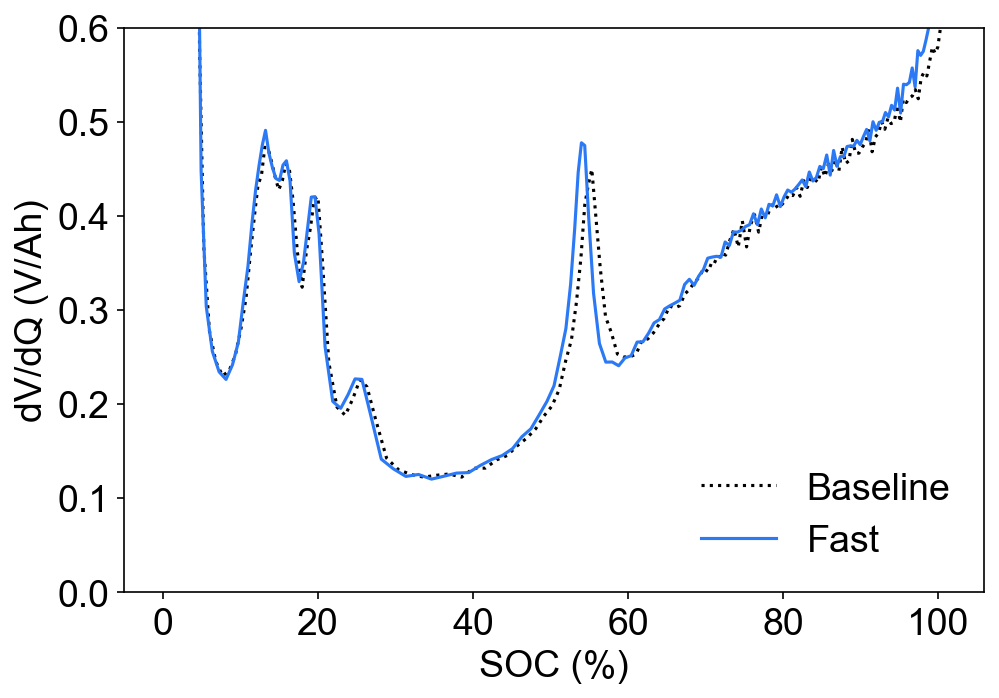

In [17]:
c20_base_list = cell_dict[CELL_BASE].process_diagnostic_c20_data()
c20_fast_list = cell_dict[CELL_FAST].process_diagnostic_c20_data()

df_c20_base = c20_base_list[0]
df_c20_fast = c20_fast_list[0]

plt.figure()
plt.plot(df_c20_base['chg_capacity']/np.max(df_c20_fast['chg_capacity'])*100, 
         df_c20_base['chg_dvdq'], linestyle=LINESTYLE_BASE, color=COLOR_BASE)

plt.plot(df_c20_fast['chg_capacity']/np.max(df_c20_fast['chg_capacity'])*100, 
         df_c20_fast['chg_dvdq'], linestyle=LINESTYLE_FAST, color=COLOR_FAST)

plt.ylim((0, 0.6))
plt.xlabel('SOC (%)')
plt.ylabel('dV/dQ (V/Ah)')
plt.legend(['Baseline', 'Fast'], frameon=False)

# Figure 2: Main Correlation Results

/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https:

(0.8, 2.4)

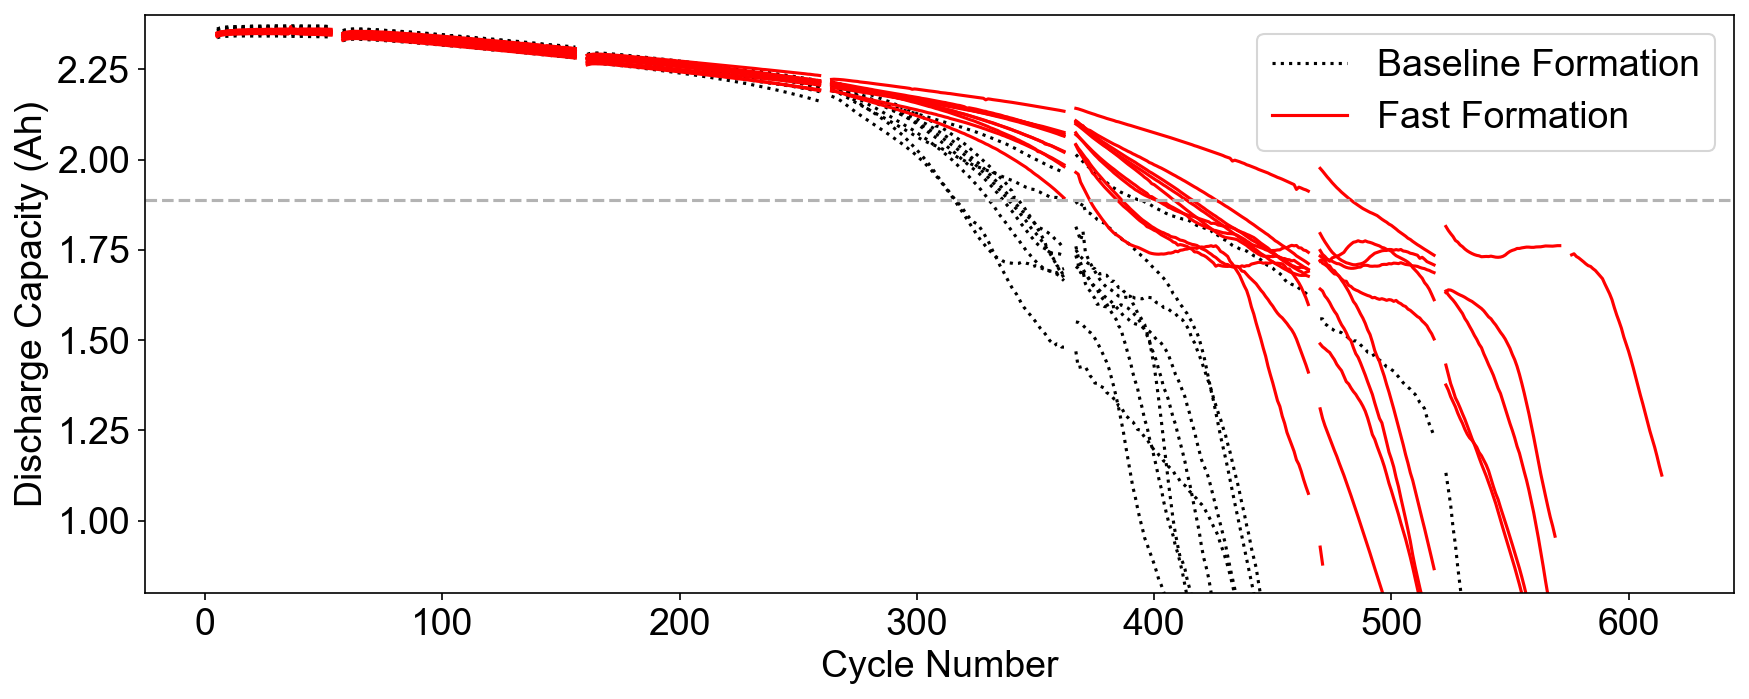

In [18]:
cellid_list = np.arange(1, 41)

plt.figure(figsize=(12, 5))
for cellid in cellid_list:
    cell = FormationCell(cellid)
    
    if cell.is_room_temp() or cell.cellid == 9:
        continue
        
    if cell.is_baseline_formation():
        color = COLOR_BASE
        linestyle = LINESTYLE_BASE
    else:
        color = COLOR_FAST_HT
        linestyle = LINESTYLE_FAST
        
    df = cell.get_aging_data_cycles()
    
    idx = np.where((df['Total Charge Time (s)'] > 8500) |
                   (df['Total Charge Time (s)'] < 100))[0]
    df['Discharge Capacity (Ah)'][idx] = np.nan
    
    cyc = df['Cycle Number']
    cap = df['Discharge Capacity (Ah)']
    
    plt.plot(cyc, cap, 
             color=color, linestyle=linestyle)
    
plt.plot(np.nan, np.nan, label='Baseline Formation',
        color=COLOR_BASE, linestyle=LINESTYLE_BASE)
plt.plot(np.nan, np.nan, label='Fast Formation',
        color=COLOR_FAST_HT, linestyle=LINESTYLE_FAST)
plt.axhline(y=TARGET_RETENTION*NOMINAL_CAPACITY_AH, 
            color=COLOR_REF, linestyle='--')
plt.legend()
plt.xlabel('Cycle Number')
plt.ylabel('Discharge Capacity (Ah)')
plt.ylim(CAPACITY_LIMITS_AH)

/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https:

(0.8, 2.4)

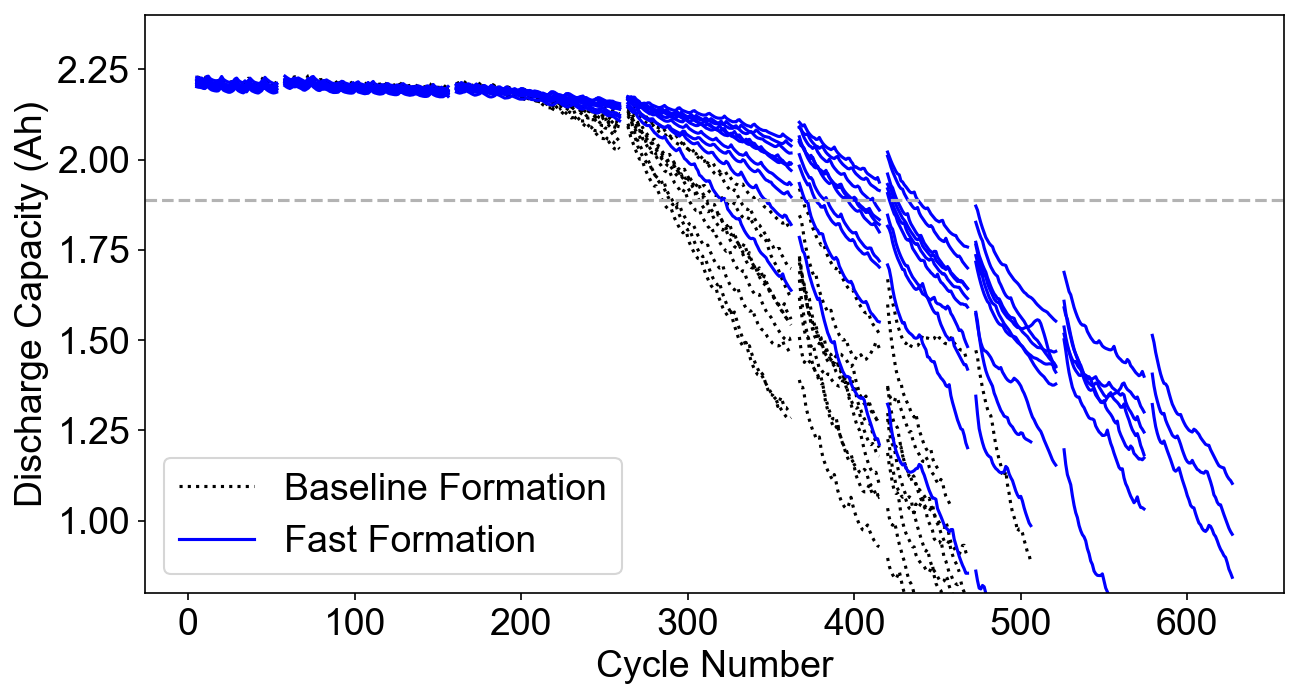

In [19]:
plt.figure(figsize=(9, 5))

for cellid in cellid_list:
    cell = FormationCell(cellid)
    
    if not cell.is_room_temp() or cell.cellid == 9:
        continue
        
    if cell.is_baseline_formation():
        color = COLOR_BASE
        linestyle = LINESTYLE_BASE
    else:
        color = COLOR_FAST_RT
        linestyle = LINESTYLE_FAST
        
    df = cell.get_aging_data_cycles()
    
    idx = np.where((df['Total Charge Time (s)'] > 8500) |
                   (df['Total Charge Time (s)'] < 100))[0]
    df['Discharge Capacity (Ah)'][idx] = np.nan
    
    cyc = df['Cycle Number']
    cap = df['Discharge Capacity (Ah)']
    
    plt.plot(cyc, cap, 
             color=color, linestyle=linestyle)

plt.plot(np.nan, np.nan, label='Baseline Formation',
        color=COLOR_BASE, linestyle=LINESTYLE_BASE)
plt.plot(np.nan, np.nan, label='Fast Formation',
        color=COLOR_FAST_RT, linestyle=LINESTYLE_FAST)
plt.legend()    
plt.axhline(y=TARGET_RETENTION*NOMINAL_CAPACITY_AH, 
            color=COLOR_REF, linestyle='--')
plt.xlabel('Cycle Number')
plt.ylabel('Discharge Capacity (Ah)')
plt.ylim(CAPACITY_LIMITS_AH)

### Plot the correlations

In [20]:
plt.rc('figure', **{'autolayout' : True,
                    'figsize'    : (4.5, 4.5),
                    'facecolor'  : 'white',
                    'dpi'        : 100
                    })

### Label registry stores mapping from variable name to label name

<ipython-input-34-108629267e2f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['esoh_c3_Cn'][df['esoh_c3_Cn'] > 3] = np.nan
<ipython-input-34-108629267e2f>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['esoh_c3_CnCp'][df['esoh_c3_CnCp'] > 1.2] = np.nan
<ipython-input-34-108629267e2f>:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


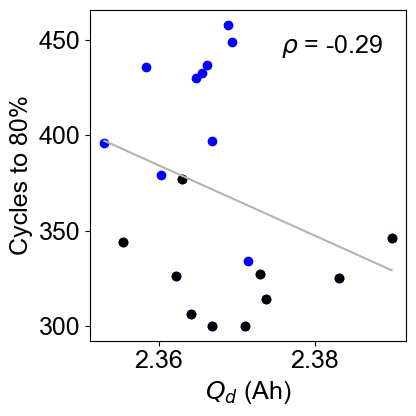

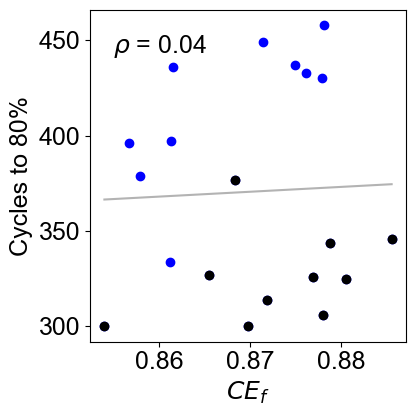

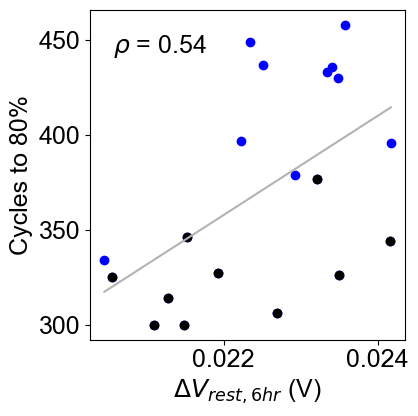

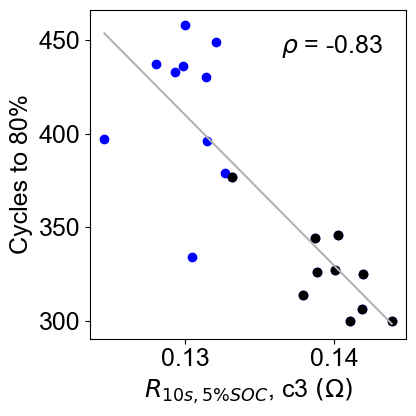

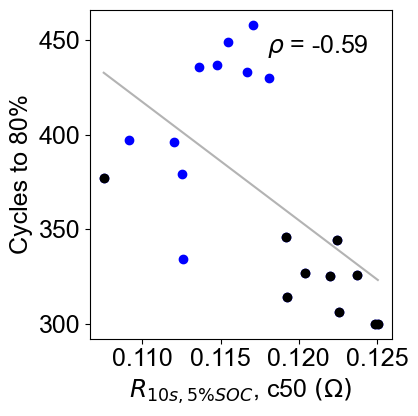

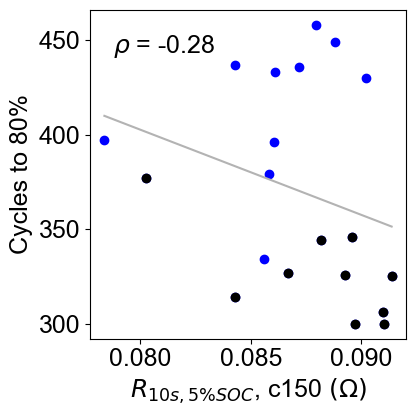

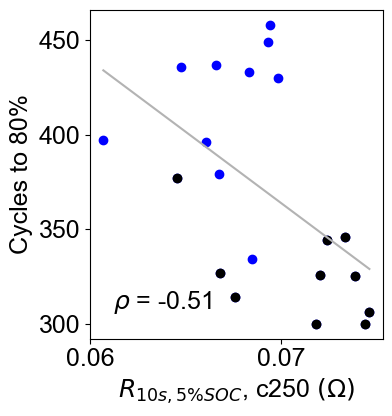

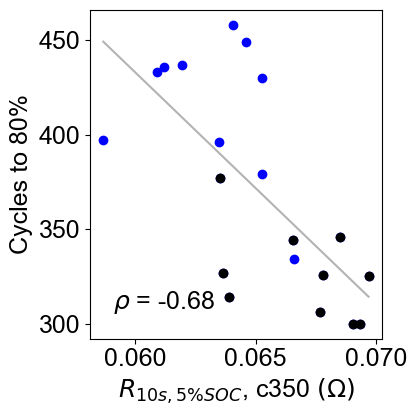

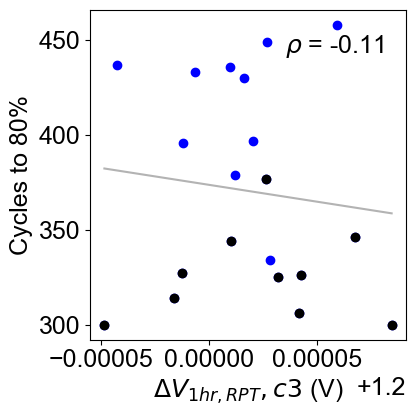

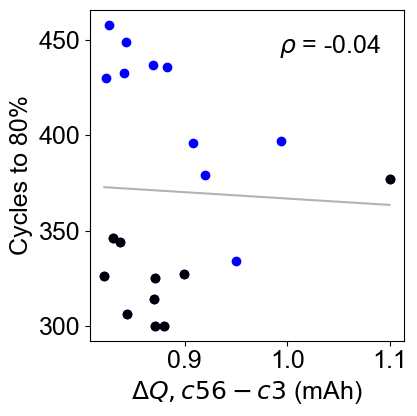

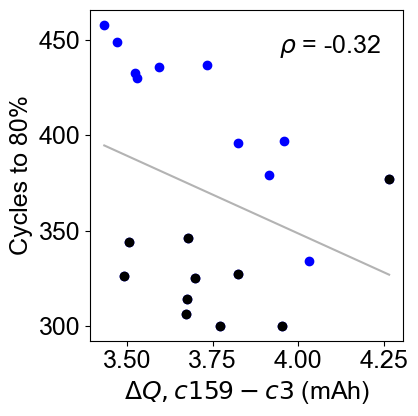

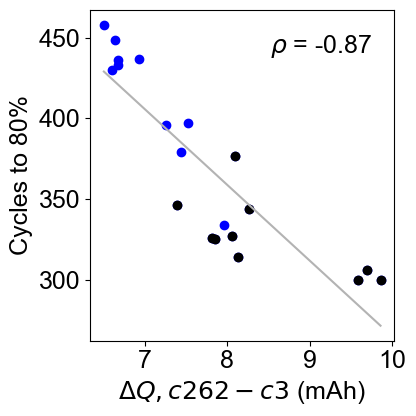

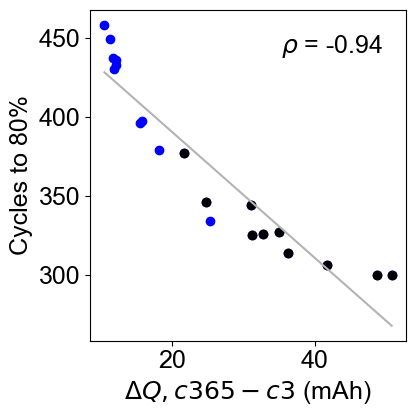

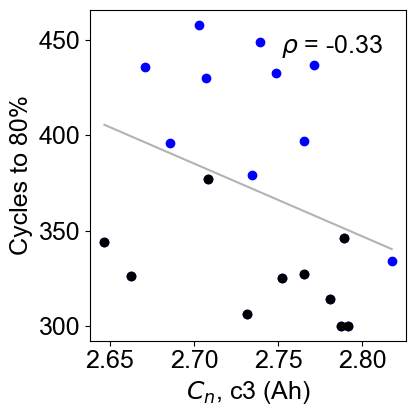

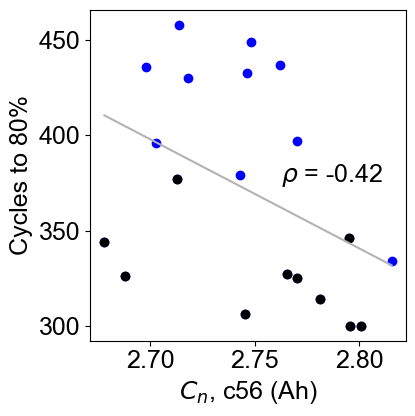

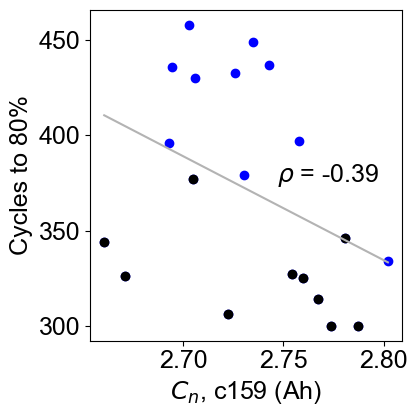

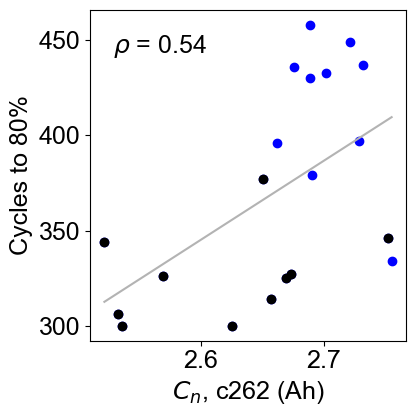

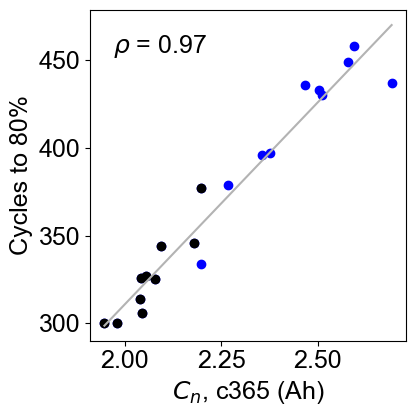

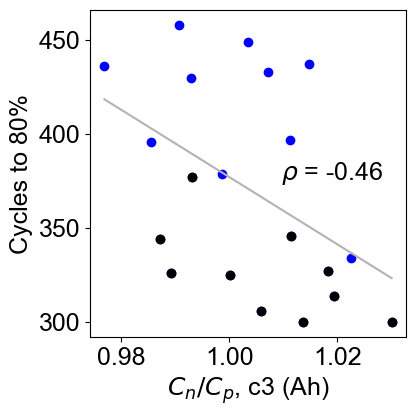

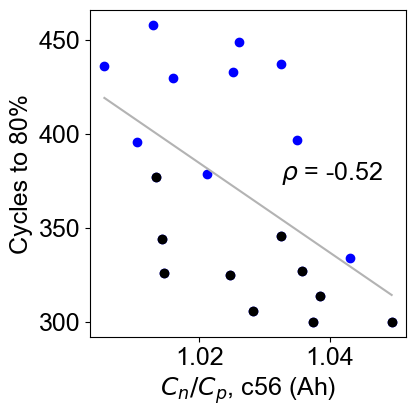

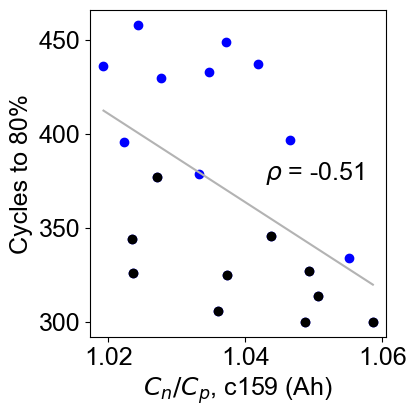

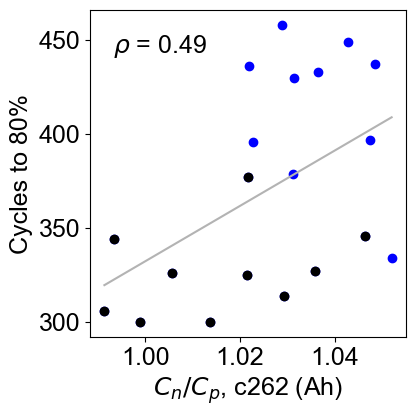

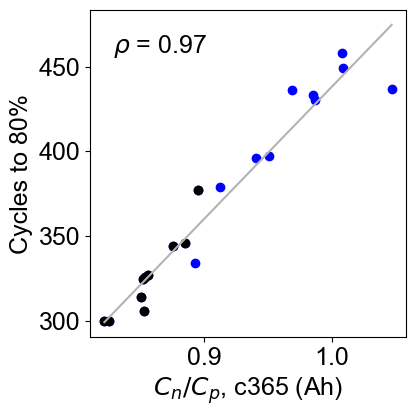

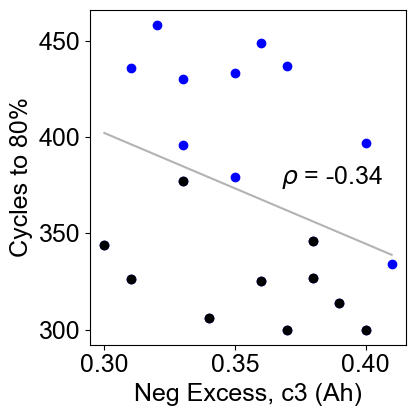

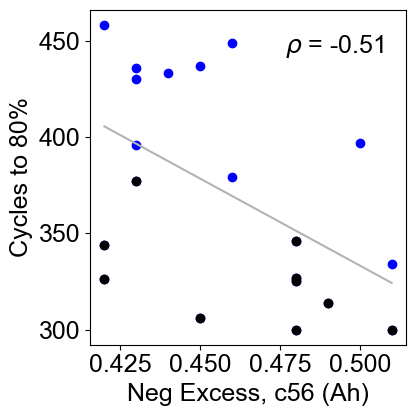

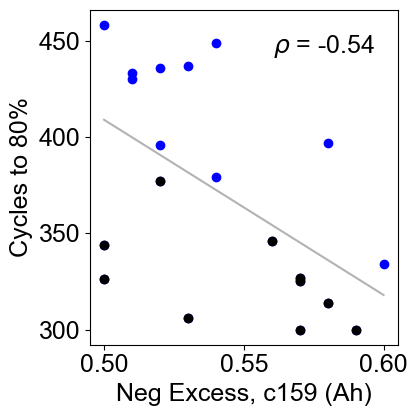

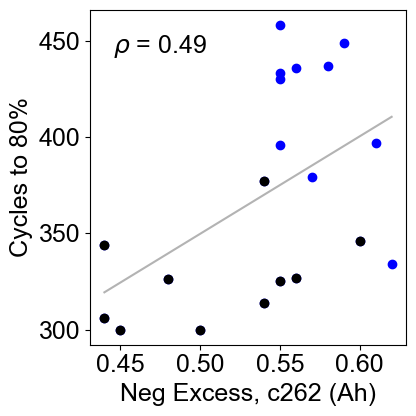

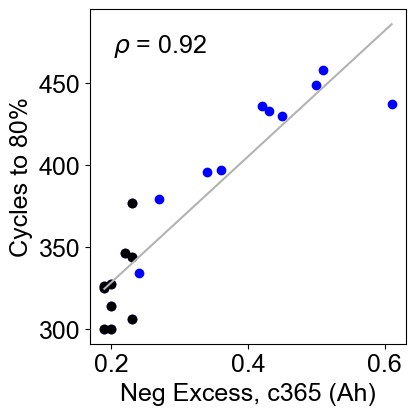

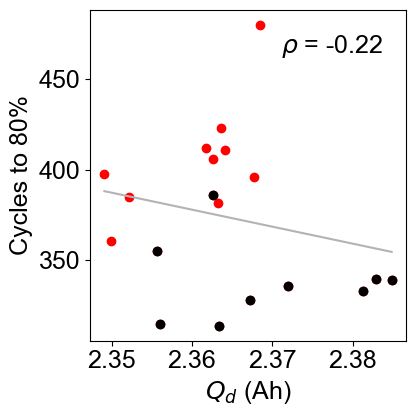

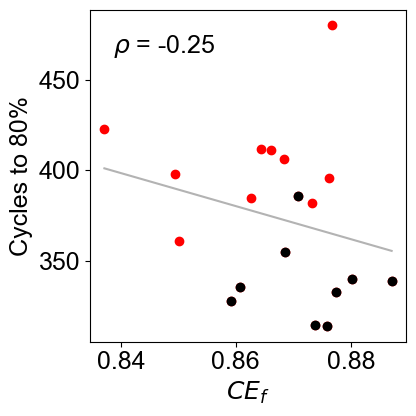

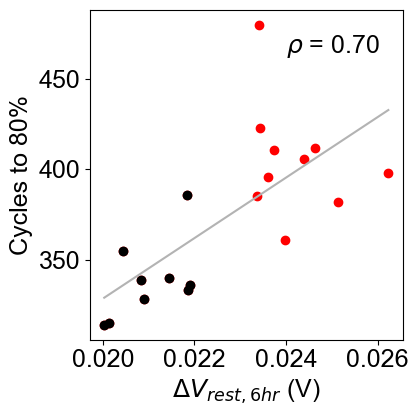

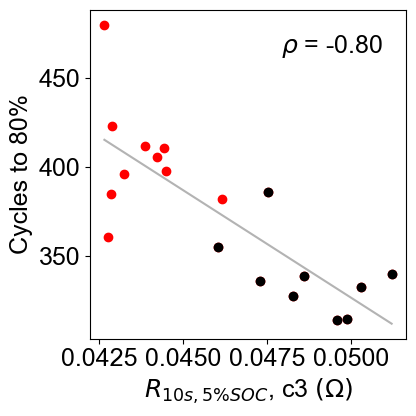

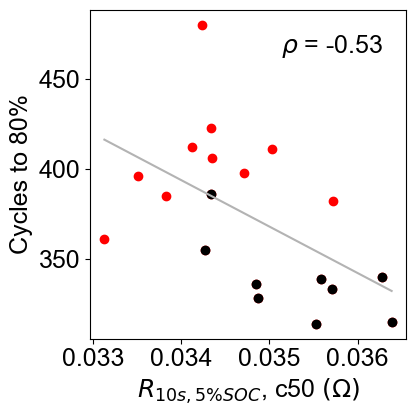

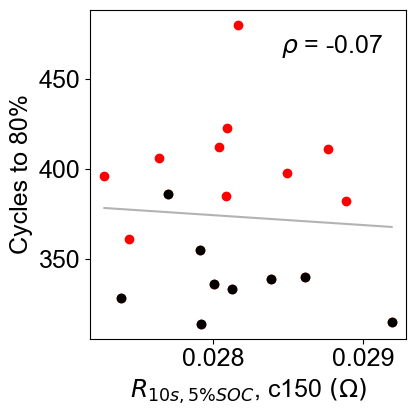

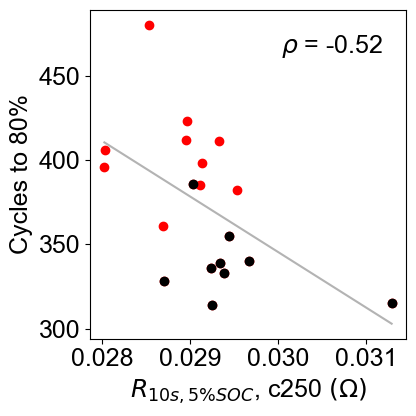

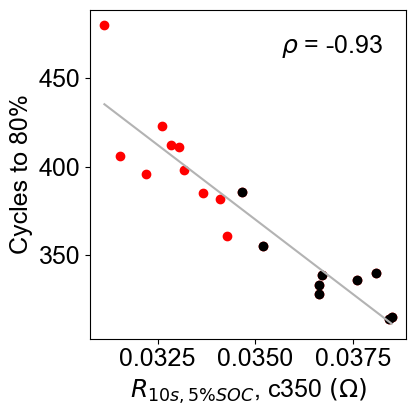

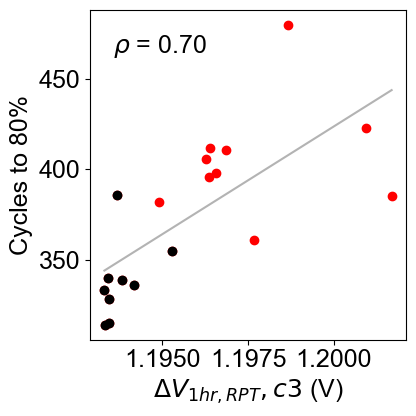

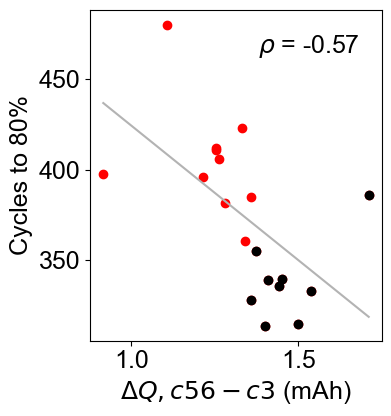

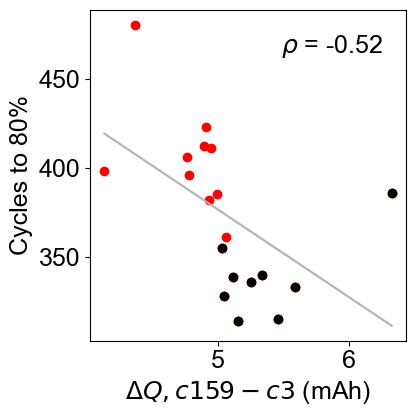

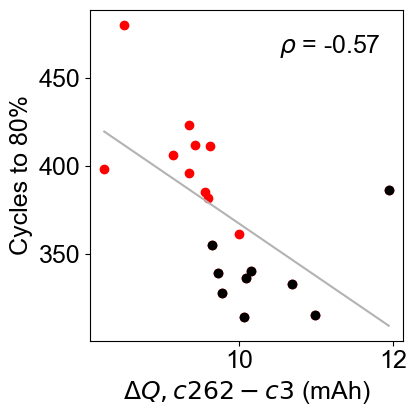

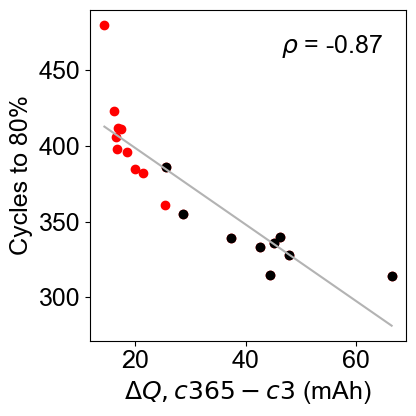

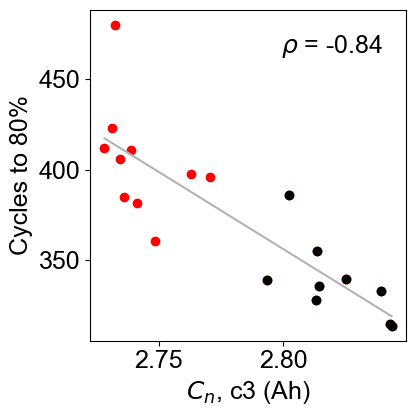

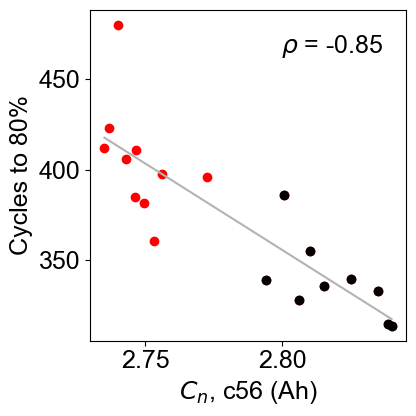

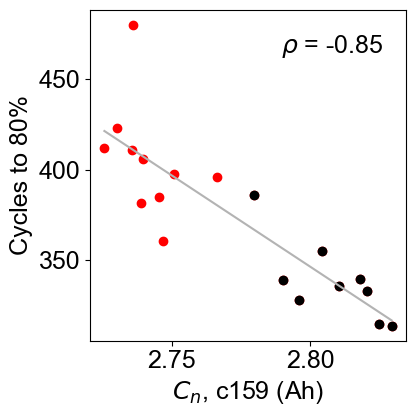

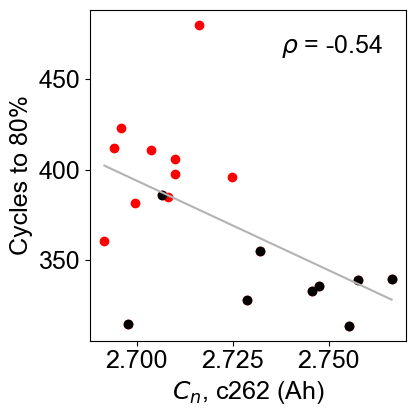

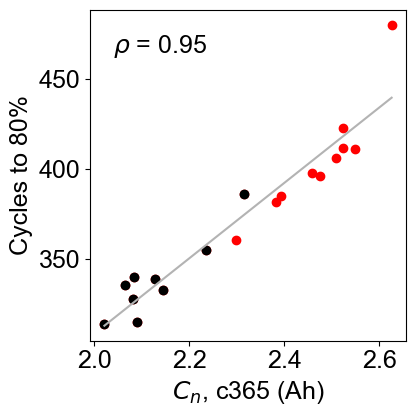

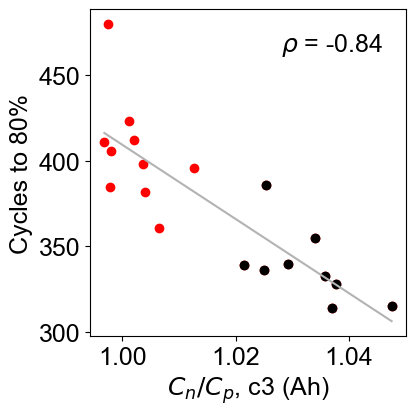

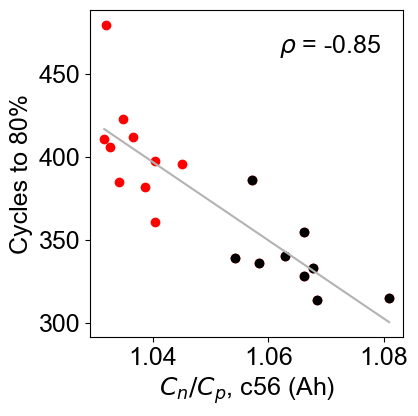

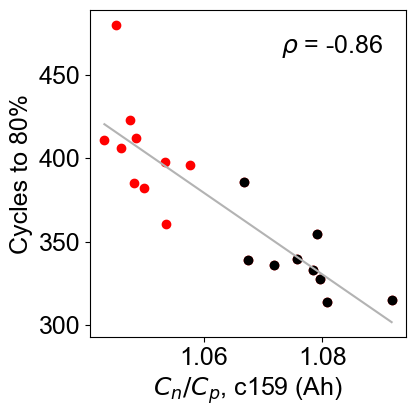

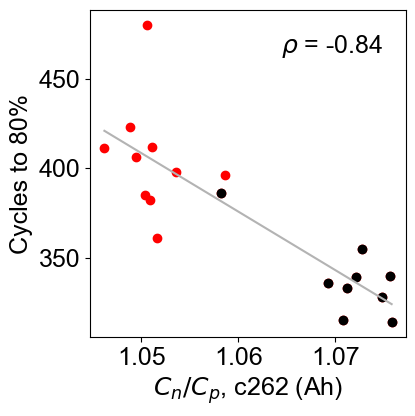

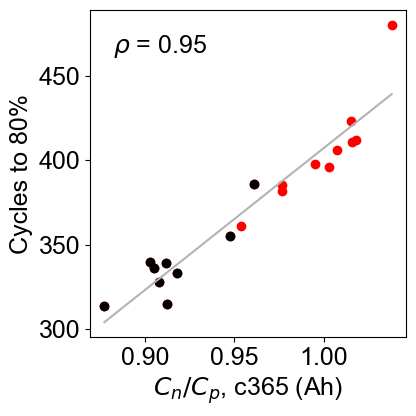

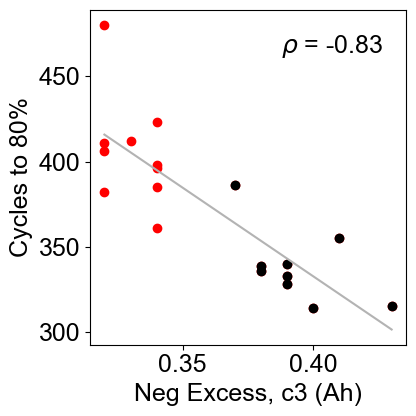

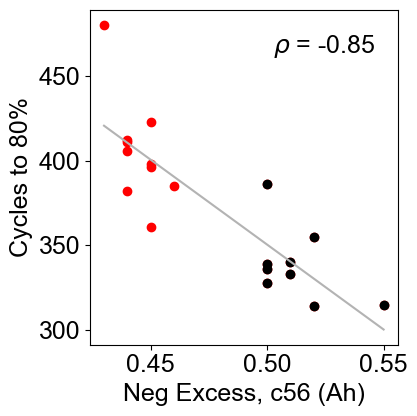

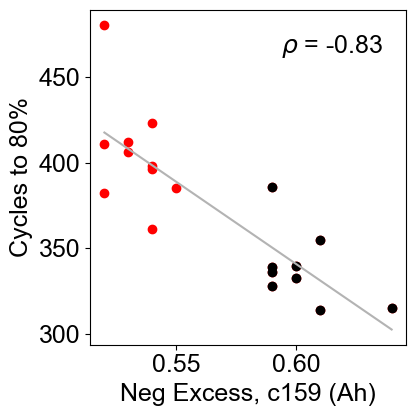

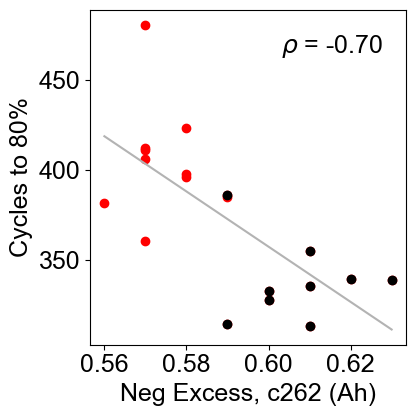

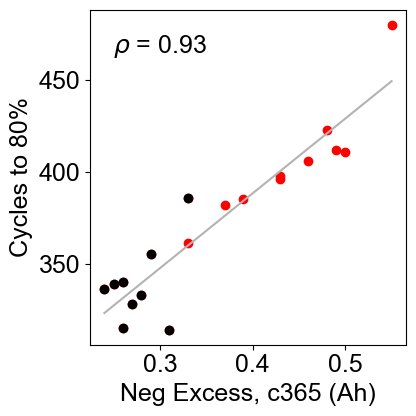

In [34]:
label_registry = get_label_registry()

path = 'output/2021-03-fast-formation-esoh-fits/correlation_data.csv';

df = pd.read_csv(path)

cyc_idx_rpt_arr = [3, 56, 159, 262, 365]

df = df[df['cellid'] != 9]
df['var_q_c56_c3'] *= 1000
df['var_q_c159_c3'] *= 1000
df['var_q_c262_c3'] *= 1000
df['var_q_c365_c3'] *= 1000

df['esoh_c3_Cn'][df['esoh_c3_Cn'] > 3] = np.nan 
df['esoh_c3_CnCp'][df['esoh_c3_CnCp'] > 1.2] = np.nan
df_rt = df[df['is_room_temp_aging'] == 1]
df_ht = df[df['is_room_temp_aging'] == 0]

xvar_array = ['form_final_discharge_capacity_ah',
              'form_coulombic_efficiency',
              'form_6hr_rest_delta_voltage_v',
              'dcr_10s_5_soc_at_c3', 
              'dcr_10s_5_soc_at_c50', 
              'dcr_10s_5_soc_at_c150', 
              'dcr_10s_5_soc_at_c250', 
              'dcr_10s_5_soc_at_c350',
              'rpt_c3_delta_v']

[xvar_array.append(f'var_q_c{x}_c3') for x in cyc_idx_rpt_arr[1::] ]
[xvar_array.append(f'esoh_c{x}_Cn') for x in cyc_idx_rpt_arr ]
[xvar_array.append(f'esoh_c{x}_CnCp') for x in cyc_idx_rpt_arr ]
[xvar_array.append(f'esoh_c{x}_neg_excess') for x in cyc_idx_rpt_arr ]

yvar = 'cycles_to_80_pct'

df_array = [df_rt, df_ht]
color_fast_array = [COLOR_FAST_RT, COLOR_FAST_HT]

# Loop over temperatures
for df, color_fast in zip(df_array, color_fast_array): 
    
    # Loop over x-variables
    for xvar in xvar_array:

        model = LinearRegression()

        x = df[xvar].values
        y = df[yvar].values
        idx_to_keep = ~np.isnan(x)
        x = x[idx_to_keep]
        y = y[idx_to_keep]

        corr, _ = pearsonr(x, y)
        model.fit(x.reshape(-1, 1), y)
        x_fit = np.linspace(np.min(x), np.max(x), 100)
        y_fit = model.predict(x_fit.reshape(-1, 1))
        
        idx_base = np.where(df['is_baseline_formation'])[0]
        idx_fast = np.where(~df['is_baseline_formation'])[0]

        plt.figure()

        plt.plot(df[xvar].iloc[idx_fast], df[yvar].iloc[idx_fast], 
                 linestyle='None', marker='o',
                 color=color_fast, label='')

        plt.plot(df[xvar].iloc[idx_base], df[yvar].iloc[idx_base], 
                 linestyle='None', marker='o',
                 color=COLOR_BASE, label='')

#         if corr**2 > 0.5:
        plt.plot(x_fit, y_fit, color=COLOR_REF, label='')
        plt.plot(np.nan, np.nan, label=rf'$\rho$ = {corr:.2f}',
                     marker='None', linestyle='None')

        leg = plt.legend(frameon=False,
                             handletextpad=0, handlelength=0)

#         plt.xlim(label_registry[xvar][1])
        plt.xlim((None, None))
        plt.xlabel(label_registry[xvar][0])
        plt.ylabel(label_registry[yvar][0])


In [22]:
# These are the available variables for plotting
for key in sorted(df.keys()):
    print(key)

Unnamed: 0
cellid
channel_number
cycles_to_50_pct
cycles_to_60_pct
cycles_to_70_pct
cycles_to_80_pct
dcr_10s_0_soc_at_c100
dcr_10s_0_soc_at_c150
dcr_10s_0_soc_at_c159
dcr_10s_0_soc_at_c200
dcr_10s_0_soc_at_c250
dcr_10s_0_soc_at_c262
dcr_10s_0_soc_at_c3
dcr_10s_0_soc_at_c300
dcr_10s_0_soc_at_c350
dcr_10s_0_soc_at_c365
dcr_10s_0_soc_at_c400
dcr_10s_0_soc_at_c450
dcr_10s_0_soc_at_c50
dcr_10s_0_soc_at_c56
dcr_10s_100_soc_at_c100
dcr_10s_100_soc_at_c150
dcr_10s_100_soc_at_c159
dcr_10s_100_soc_at_c200
dcr_10s_100_soc_at_c250
dcr_10s_100_soc_at_c262
dcr_10s_100_soc_at_c3
dcr_10s_100_soc_at_c300
dcr_10s_100_soc_at_c350
dcr_10s_100_soc_at_c365
dcr_10s_100_soc_at_c400
dcr_10s_100_soc_at_c450
dcr_10s_100_soc_at_c50
dcr_10s_100_soc_at_c56
dcr_10s_10_soc_at_c100
dcr_10s_10_soc_at_c150
dcr_10s_10_soc_at_c159
dcr_10s_10_soc_at_c200
dcr_10s_10_soc_at_c250
dcr_10s_10_soc_at_c262
dcr_10s_10_soc_at_c3
dcr_10s_10_soc_at_c300
dcr_10s_10_soc_at_c350
dcr_10s_10_soc_at_c365
dcr_10s_10_soc_at_c400
dcr_10s_10_s

# Figure 3: Explanation of $C_n$ effect on Low-SOC Resistance

In [23]:
# Look at the results from the lowest cycle index for each cell
esoh_data_base = cell_dict[CELL_BASE].get_esoh_fitting_data()[0]
esoh_data_fast = cell_dict[CELL_FAST].get_esoh_fitting_data()[0]

assert esoh_data_base['cycle_index'] == 3
assert esoh_data_fast['cycle_index'] == 3

### Available keys

Text(0, 0.5, 'dV/dQ (V/Ah)')

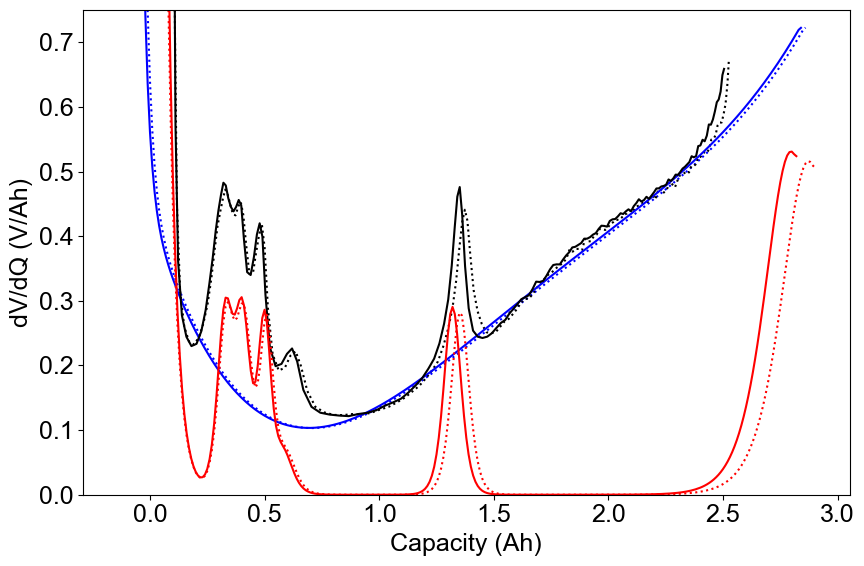

In [24]:
# dV/dQ

esoh_data_base = cell_dict[CELL_BASE].get_esoh_fitting_data()[0]
esoh_data_fast = cell_dict[CELL_FAST].get_esoh_fitting_data()[0]
assert esoh_data_base['cycle_index'] == 3
assert esoh_data_fast['cycle_index'] == 3
fig, ax = plt.subplots(figsize=(9,6))
    
plt.plot(esoh_data_base['pos']['Q'], esoh_data_base['pos']['dVdQ'], color=COLOR_POS, linestyle=':')
plt.plot(esoh_data_base['orig']['Q'], esoh_data_base['orig']['dVdQ'], color=COLOR_FULL_CELL, linestyle=':')
plt.plot(esoh_data_fast['pos']['Q'], esoh_data_fast['pos']['dVdQ'], color=COLOR_POS)
plt.plot(esoh_data_fast['orig']['Q'], esoh_data_fast['orig']['dVdQ'], color=COLOR_FULL_CELL)
plt.plot(esoh_data_base['neg']['Q'], esoh_data_base['neg']['dVdQ'], color=COLOR_NEG, linestyle=':')
plt.plot(esoh_data_fast['neg']['Q'], esoh_data_fast['neg']['dVdQ'], color=COLOR_NEG)

plt.ylim((0, 0.75))
plt.xlabel('Capacity (Ah)')
plt.ylabel('dV/dQ (V/Ah)')

Text(0, 0.5, 'dV/dQ (V/Ah)')

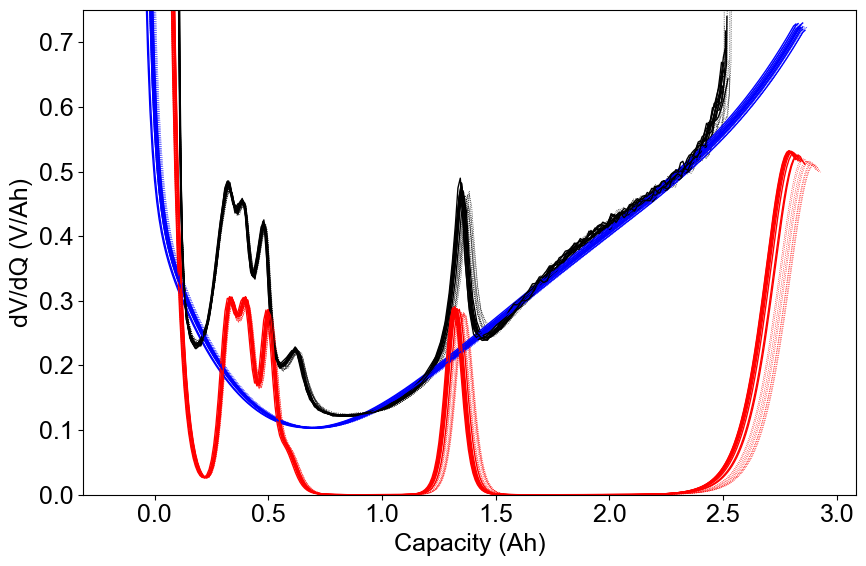

In [25]:
# dV/dQ
fig, ax = plt.subplots(figsize=(9,6))

for cellid in cellid_list:
    
    cell = cell_dict[cellid]
    
    if cell.is_room_temp() or cell.cellid == 9:
        continue
        
    if cell.is_baseline_formation():
        linestyle = ':'
        linewidth = 0.5
    else:
        linestyle = '-'
        linewidth = 1
        
    esoh_data = cell.get_esoh_fitting_data()[0]
    assert esoh_data['cycle_index'] == 3
        
    plt.plot(esoh_data['pos']['Q'], esoh_data['pos']['dVdQ'], 
             color=COLOR_POS, linestyle=linestyle, linewidth=linewidth)
    plt.plot(esoh_data['orig']['Q'], esoh_data['orig']['dVdQ'], 
             color=COLOR_FULL_CELL, linestyle=linestyle, linewidth=linewidth)
    plt.plot(esoh_data['neg']['Q'], esoh_data['neg']['dVdQ'], 
             color=COLOR_NEG, linestyle=linestyle, linewidth=linewidth)

plt.ylim((0, 0.75))
plt.xlabel('Capacity (Ah)')
plt.ylabel('dV/dQ (V/Ah)')

In [26]:
xlim_array = [(-0.3, 3), 
              (-0.10, 0.3),
              (2.45, 2.6)]

neg_ylim_array = [(-0.05, 1.05),
                  (-0.05, 1.05),
                  (0.08, 0.095)]

pos_ylim_array = [(2.4, 4.55), 
                  (2.95, 3.75),
                  (4.10, 4.39)]

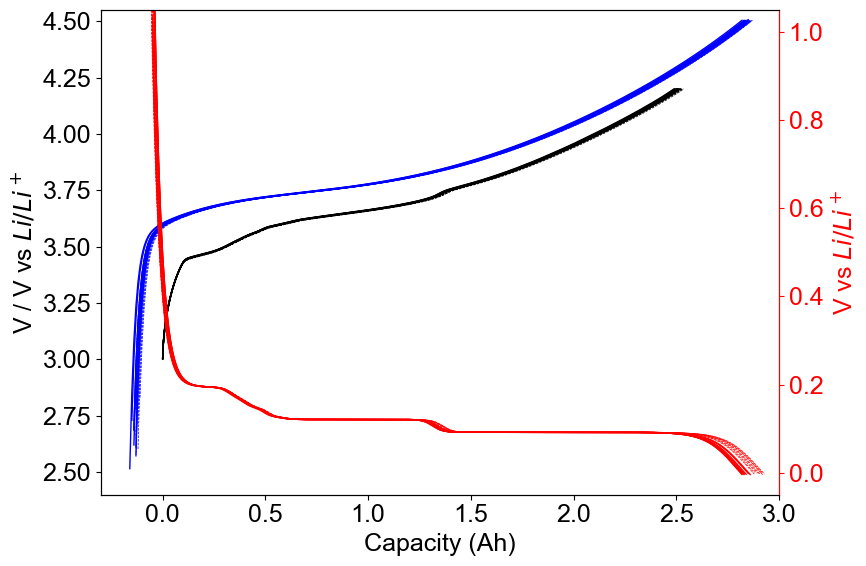

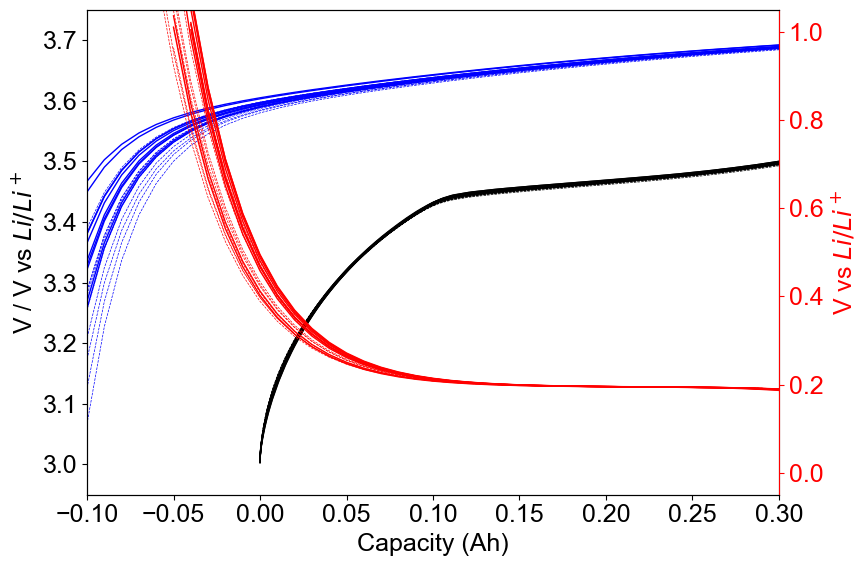

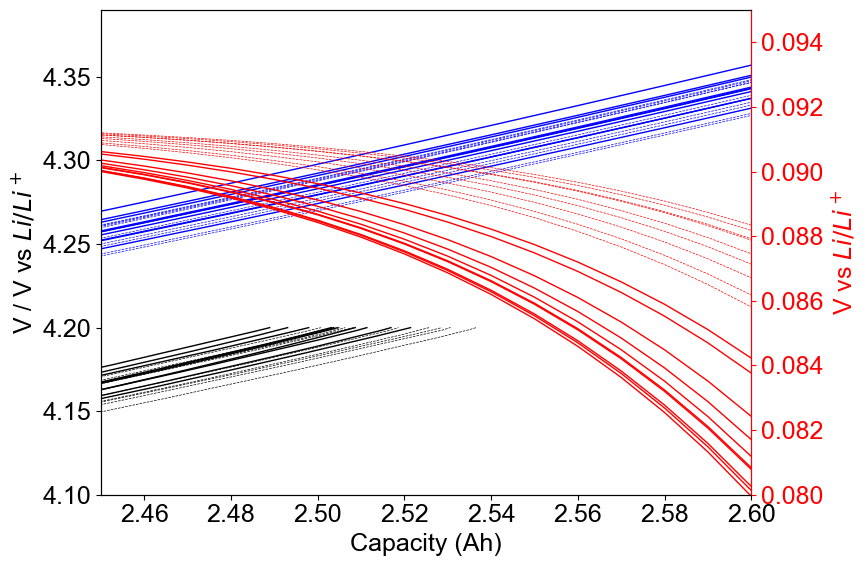

In [27]:
fig_arr, ax_arr, ax2_arr = [], [], []

for (xlim, neg_ylim, pos_ylim) in zip(xlim_array, neg_ylim_array, pos_ylim_array):

    fig, ax = plt.subplots(figsize=(9,6))
    ax2 = ax.twinx()
    
    fig_arr.append(fig)
    ax_arr.append(ax)
    ax2_arr.append(ax2)
    
    for cellid in cellid_list:
        
        cell = cell_dict[cellid]

        if cell.is_room_temp() or cell.cellid == 9:
            continue
            
        if cell.is_baseline_formation():
            linestyle = '--'
            linewidth = 0.5
        else:
            linestyle = '-'
            linewidth = 1

        esoh_data = cell.get_esoh_fitting_data()[0]
        assert esoh_data['cycle_index'] == 3        

        ax.plot(esoh_data['pos']['Q'], esoh_data['pos']['V'], 
                color=COLOR_POS, linestyle=linestyle, linewidth=linewidth)
        ax.plot(esoh_data['orig']['Q'], esoh_data['orig']['V'], 
                color=COLOR_FULL_CELL, linestyle=linestyle, linewidth=linewidth)
        ax2.plot(esoh_data['neg']['Q'], esoh_data['neg']['V'], 
                 color=COLOR_NEG, linestyle=linestyle, linewidth=linewidth)

        ax.set_xlabel('Capacity (Ah)')
        ax2.yaxis.label.set_color(COLOR_NEG)
        ax2.spines["right"].set_edgecolor(COLOR_NEG)
        ax2.tick_params(axis='y', colors=COLOR_NEG)

        ax.set_ylabel('V / V vs $Li/Li^+$')
        ax2.set_ylabel('V vs $Li/Li^+$')
        ax.set_xlim(xlim)
        ax2.set_ylim(neg_ylim)
        ax.set_ylim(pos_ylim)

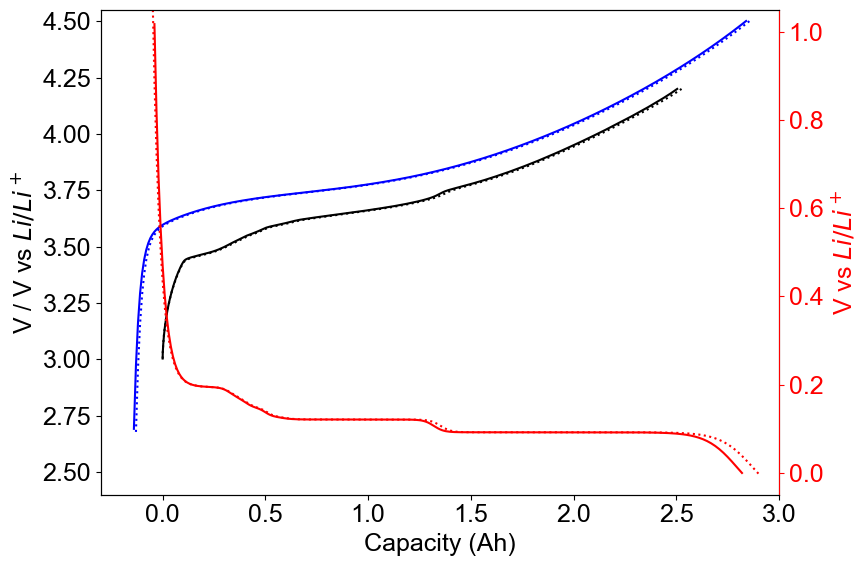

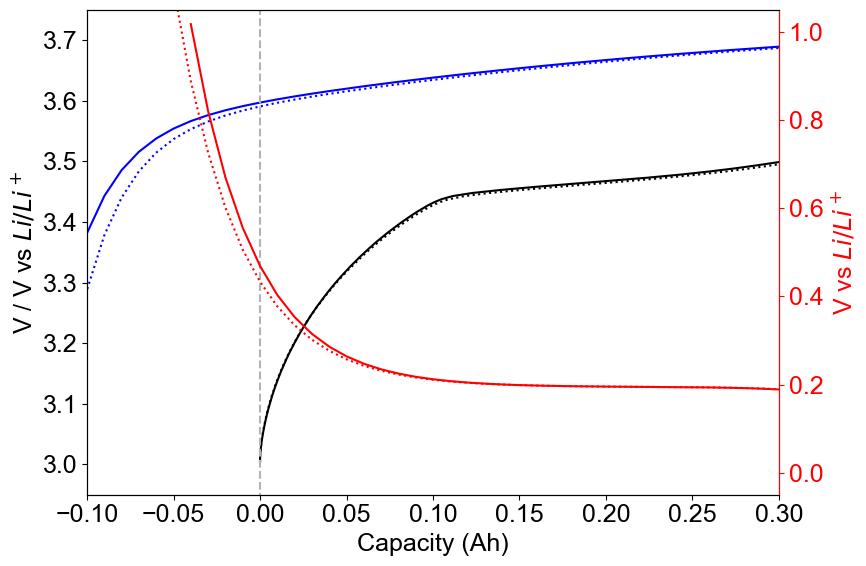

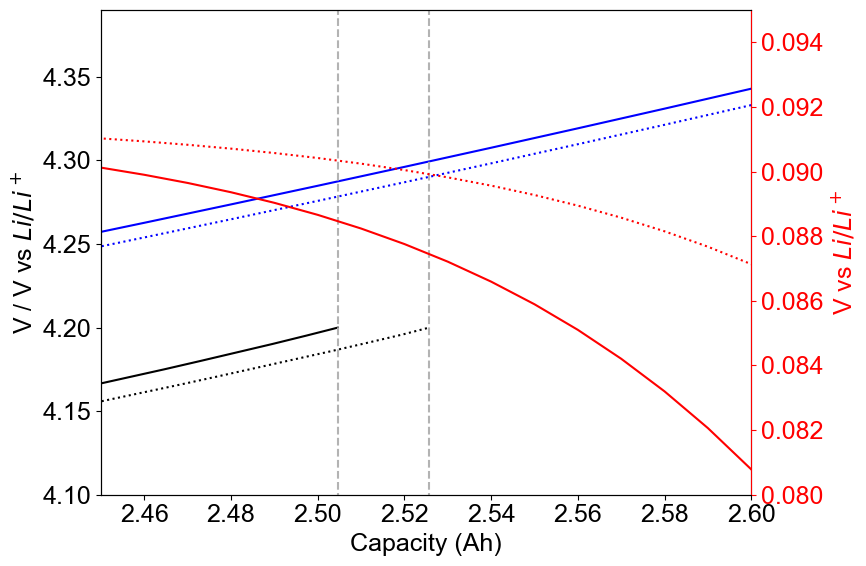

In [28]:
fig_arr, ax_arr, ax2_arr = [], [], []

for (xlim, neg_ylim, pos_ylim) in zip(xlim_array, neg_ylim_array, pos_ylim_array):

    fig, ax = plt.subplots(figsize=(9,6))
    ax2 = ax.twinx()
    
    fig_arr.append(fig)
    ax_arr.append(ax)
    ax2_arr.append(ax2)
    
    ax.plot(esoh_data_base['pos']['Q'], esoh_data_base['pos']['V'], color=COLOR_POS, linestyle=':')
    ax.plot(esoh_data_base['orig']['Q'], esoh_data_base['orig']['V'], color=COLOR_FULL_CELL, linestyle=':')

    ax.plot(esoh_data_fast['pos']['Q'], esoh_data_fast['pos']['V'], color=COLOR_POS)
    ax.plot(esoh_data_fast['orig']['Q'], esoh_data_fast['orig']['V'], color=COLOR_FULL_CELL)

    ax2.plot(esoh_data_base['neg']['Q'], esoh_data_base['neg']['V'], color=COLOR_NEG, linestyle=':')
    ax2.plot(esoh_data_fast['neg']['Q'], esoh_data_fast['neg']['V'], color=COLOR_NEG)
    
    ax.set_xlabel('Capacity (Ah)')
    ax2.yaxis.label.set_color(COLOR_NEG)
    ax2.spines["right"].set_edgecolor(COLOR_NEG)
    ax2.tick_params(axis='y', colors=COLOR_NEG)

    ax.set_ylabel('V / V vs $Li/Li^+$')
    ax2.set_ylabel('V vs $Li/Li^+$')
    ax.set_xlim(xlim)
    ax2.set_ylim(neg_ylim)
    ax.set_ylim(pos_ylim)

ax_arr[1].plot([0, 0], [0, 5], color=COLOR_REF, linestyle='--')

ax_arr[2].plot([esoh_data_base['orig']['Q'][-1], esoh_data_base['orig']['Q'][-1]], 
               [0, 5], color=COLOR_REF, linestyle='--')
ax_arr[2].plot([esoh_data_fast['orig']['Q'][-1], esoh_data_fast['orig']['Q'][-1]], 
               [0, 5], color=COLOR_REF, linestyle='--')

Comparison of metrics

In [29]:
df = pd.DataFrame([esoh_data_base, esoh_data_fast], index=['baseline', 'fast'])
df = df.drop(columns=['ful', 'pos', 'neg', 'orig', 'Xt'])
# df = df.transpose()
df

np_ratio        Cp        Cn      y100        y0        x0  \
baseline  1.024909  2.745839  2.814234  0.036516  0.954269  0.009107   
fast      0.998022  2.739773  2.734355  0.037883  0.950368  0.007241   

              x100      n_li  Cn_excess  Cp_excess    Cf    RMSE_mV     Cn_pf  \
baseline  0.904555  0.098722       0.38       0.13  2.52  29.161407  2.897052   
fast      0.921533  0.097890       0.32       0.14  2.50  21.222650  2.856612   

           x100_pf  cycle_index  
baseline  0.883757          3.0  
fast      0.889973          3.0

Percentage changes:

In [30]:
df.pct_change(axis='rows')*100

np_ratio        Cp      Cn      y100        y0         x0      x100  \
baseline       NaN       NaN     NaN       NaN       NaN        NaN       NaN   
fast     -2.623304 -0.220891 -2.8384  3.744317 -0.408782 -20.493076  1.876974   

              n_li  Cn_excess  Cp_excess        Cf    RMSE_mV     Cn_pf  \
baseline       NaN        NaN        NaN       NaN        NaN       NaN   
fast     -0.843041 -15.789474   7.692308 -0.793651 -27.223503 -1.395904   

           x100_pf  cycle_index  
baseline       NaN          NaN  
fast      0.703426          0.0